# Project Documentation

## Overview

This project demonstrates how to use OpenAI's GPT models for various tasks, including text generation, summarization, and code assistance. The workflow showcases prompt engineering, API usage, and integration with Python scripts.

## Features

- **Prompt Engineering:** Crafting effective prompts for different tasks.
- **API Integration:** Using OpenAI's API for text generation and summarization.
- **Code Assistance:** Leveraging GPT for code suggestions and debugging.
- **Workflow Documentation:** Step-by-step explanations and markdown documentation.

## Usage

1. **Set Up API Key:**  
    Store your OpenAI API key securely as an environment variable.
    ```python
    import os
    os.environ["OPENAI_API_KEY"] = "your-api-key"
    ```

2. **Install Dependencies:**  
    Ensure you have the required packages installed.
    ```bash
    pip install openai
    ```

3. **Example: Generate Text**
    ```python
    import openai

    response = openai.ChatCompletion.create(
         model="gpt-3.5-turbo",
         messages=[
              {"role": "system", "content": "You are a helpful assistant."},
              {"role": "user", "content": "Summarize the following text..."}
         ]
    )
    print(response.choices[0].message["content"])
    ```

4. **Prompt Engineering Tips:**
    - Be explicit with instructions.
    - Provide context and examples.
    - Specify output format if needed.

## Best Practices

- **Security:** Never expose your API key in public repositories.
- **Efficiency:** Reuse prompts and cache responses where possible.
- **Documentation:** Use markdown cells to explain each step and decision.

## References

- [OpenAI API Documentation](https://platform.openai.com/docs/)
- [Prompt Engineering Guide](https://www.promptingguide.ai/)

---

*This README was generated based on the workflow and code shared in the referenced project.*

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("shashanknecrothapa/ames-housing-dataset")

print("Path to dataset files:", path)

Note: you may need to restart the kernel to use updated packages.


100%|██████████| 185k/185k [00:00<00:00, 2.40MB/s]

Extracting files...
Path to dataset files: /home/jake/.cache/kagglehub/datasets/shashanknecrothapa/ames-housing-dataset/versions/1


Cross-validated performance on train:
Linear: RMSE 0.178 ± 0.015 | MAE 0.114 ± 0.004 | R² 0.804 ± 0.029
Ridge: RMSE 0.178 ± 0.015 | MAE 0.113 ± 0.004 | R² 0.804 ± 0.029
Lasso: RMSE 0.179 ± 0.016 | MAE 0.114 ± 0.004 | R² 0.801 ± 0.032
Best by validation RMSE: Lasso
TEST -> RMSE: 0.165 | MAE: 0.112 | R²: 0.842


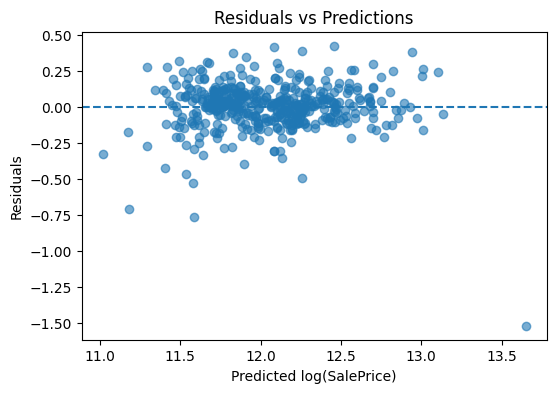

In [ ]:
# !pip install scikit-learn pandas numpy matplotlib joblib

import json
import numpy as np
import pandas as pd
from pathlib import Path
from joblib import dump

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

# --- 1) Load data ---
df = pd.read_csv("../data/AmesHousing.csv")

target_col = "SalePrice"
y = np.log1p(df[target_col])
X = df.drop(columns=[target_col])

# Choose features
num_features = [
    "GrLivArea", "TotalBsmtSF", "GarageArea", "1stFlrSF", "FullBath",
    "GarageCars", "TotRmsAbvGrd", "YearBuilt", "LotArea"
]
cat_features = [
    "Neighborhood", "BldgType", "HouseStyle", "KitchenQual", "Exterior1st"
]
features = num_features + cat_features
X = X[features].copy()

# --- 2) Split ---
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.30, random_state=42
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, random_state=42
)

# --- 3) Preprocessing ---
numeric_pipe = Pipeline([
    ("impute", SimpleImputer(strategy="median")),
    ("scale", StandardScaler())
])

categorical_pipe = Pipeline([
    ("impute", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

pre = ColumnTransformer([
    ("num", numeric_pipe, num_features),
    ("cat", categorical_pipe, cat_features)
])

# --- 4) Models ---
lin = Pipeline([("pre", pre), ("model", LinearRegression())])

ridge = Pipeline([
    ("pre", pre),
    ("model", RidgeCV(alphas=np.logspace(-3, 3, 25), cv=5))
])

lasso = Pipeline([
    ("pre", pre),
    ("model", LassoCV(alphas=np.logspace(-3, 1, 25), cv=5, max_iter=20000))
])

def eval_cv(model, X, y, cv=5, name="model"):
    rmse = np.sqrt(-cross_val_score(model, X, y, cv=cv, scoring="neg_mean_squared_error"))
    mae  = -cross_val_score(model, X, y, cv=cv, scoring="neg_mean_absolute_error")
    r2   = cross_val_score(model, X, y, cv=cv, scoring="r2")
    print(f"{name}: RMSE {rmse.mean():.3f} ± {rmse.std():.3f} | "
          f"MAE {mae.mean():.3f} ± {mae.std():.3f} | R² {r2.mean():.3f} ± {r2.std():.3f}")
    return {"rmse": rmse.mean(), "mae": mae.mean(), "r2": r2.mean()}

print("Cross-validated performance on train:")
m_lin   = eval_cv(lin,   X_train, y_train, name="Linear")
m_ridge = eval_cv(ridge, X_train, y_train, name="Ridge")
m_lasso = eval_cv(lasso, X_train, y_train, name="Lasso")

# --- 5) Pick best via val set ---
models = {"Linear": lin, "Ridge": ridge, "Lasso": lasso}
val_scores = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    pred = model.predict(X_val)
    val_rmse = np.sqrt(mean_squared_error(y_val, pred))
    val_scores[name] = val_rmse
best_name = min(val_scores, key=val_scores.get)
best_model = models[best_name].fit(pd.concat([X_train, X_val]), pd.concat([y_train, y_val]))
print(f"Best by validation RMSE: {best_name}")

# --- 6) Test evaluation ---
yhat_test = best_model.predict(X_test)
test_rmse = np.sqrt(mean_squared_error(y_test, yhat_test))
test_mae  = mean_absolute_error(y_test, yhat_test)
test_r2   = r2_score(y_test, yhat_test)
print(f"TEST -> RMSE: {test_rmse:.3f} | MAE: {test_mae:.3f} | R²: {test_r2:.3f}")

# Residual plot
residuals = y_test - yhat_test
plt.figure(figsize=(6,4))
plt.scatter(yhat_test, residuals, alpha=0.6)
plt.axhline(0, linestyle="--")
plt.xlabel("Predicted log(SalePrice)")
plt.ylabel("Residuals")
plt.title("Residuals vs Predictions")
plt.show()

# --- 7) Save artifacts ---
Path("artifacts").mkdir(exist_ok=True)
dump(best_model, "artifacts/ames_linear_pipeline.joblib")

metrics = {"rmse": float(test_rmse), "mae": float(test_mae), "r2": float(test_r2),
           "model": best_name}
with open("artifacts/metrics.json", "w") as f:
    json.dump(metrics, f, indent=2)
